# Asymptotic stability constraint

In this example, three experimental EDMD-based regressors are compared to EDMD. Specifically, EDMD is compared to the asymptotic stability constraint and the
H-infinity norm regularizer from [2110.09658 [eess.SY]](https://arxiv.org/abs/2110.09658) and [2102.03613 [eess.SY]](https://arxiv.org/abs/2102.03613), and the dissipativity
constraint from [1911.03884v1 [eess.SY]](https://arxiv.org/abs/1911.03884v1).

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, linalg

import pykoop
import pykoop.lmi_regressors

# Set plot defaults
plt.rc('lines', linewidth=2)
plt.rc('axes', grid=True)
plt.rc('grid', linestyle='--')

# Set solver (you can switch to ``'mosek'`` if you have a license).
solver = 'cvxopt'

Load example data from the library. `eg` is a `dict` containing training data, validation data, and a few related parameters.

In [2]:
# Get example data
eg = pykoop.example_data_msd()

Fit standard EDMD regressor.

In [3]:
reg_no_const = pykoop.KoopmanPipeline(regressor=pykoop.Edmd())
reg_no_const.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)
U_no_const = reg_no_const.regressor_.coef_.T

Fit regressor with H-infinity norm constraint of `gamma=1.5`.

In [4]:
gamma = 1.5
Xi = np.block([
    [1 / gamma * np.eye(2), np.zeros((2, 1))],
    [np.zeros((1, 2)), -gamma * np.eye(1)],
])
reg_diss_const = pykoop.KoopmanPipeline(
    regressor=pykoop.lmi_regressors.LmiEdmdDissipativityConstr(
        supply_rate=Xi,
        solver_params={'solver': solver},
    ))
reg_diss_const.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)
U_diss_const = reg_diss_const.regressor_.coef_.T

Fit regressor with H-infinity norm regularizer.

In [5]:
reg_hinf_reg = pykoop.KoopmanPipeline(
    regressor=pykoop.lmi_regressors.LmiEdmdHinfReg(
        alpha=1e-2,
        solver_params={'solver': solver},
    ))
reg_hinf_reg.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)
U_hinf_reg = reg_hinf_reg.regressor_.coef_.T

Fit regressor with spectral radius constraint of `spectral_radius=0.8`.

In [6]:
reg_sr_const = pykoop.KoopmanPipeline(
    regressor=pykoop.lmi_regressors.LmiEdmdSpectralRadiusConstr(
        spectral_radius=0.8,
        solver_params={'solver': solver},
    ))
reg_sr_const.fit(
    eg['X_train'],
    n_inputs=eg['n_inputs'],
    episode_feature=eg['episode_feature'],
)
U_sr_const = reg_sr_const.regressor_.coef_.T

Predict trajectories with all regressors.

In [7]:
X_pred_no_const = reg_no_const.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
)
X_pred_diss_const = reg_diss_const.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
)
X_pred_hinf_reg = reg_hinf_reg.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
)
X_pred_sr_const = reg_sr_const.predict_trajectory(
    eg['x0_valid'],
    eg['u_valid'],
)

Plot all trajectories.

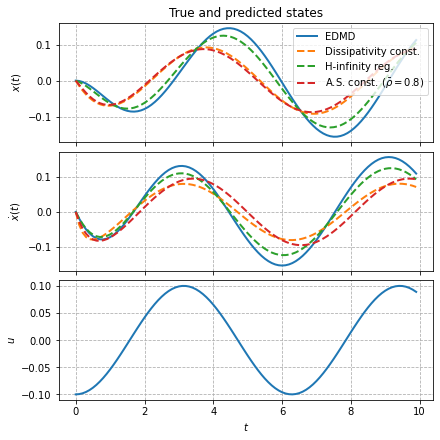

In [8]:
fig, ax = plt.subplots(
    reg_no_const.n_states_in_ + reg_no_const.n_inputs_in_,
    1,
    constrained_layout=True,
    sharex=True,
    figsize=(6, 6),
)
# Plot input
ax[2].plot(eg['t'], eg['X_valid'][:, 3])
# Plot predicted trajectory
ax[0].plot(eg['t'], X_pred_no_const[:, 1], label='EDMD')
ax[1].plot(
    eg['t'],
    X_pred_no_const[:, 2],
)
ax[0].plot(
    eg['t'],
    X_pred_diss_const[:, 1],
    '--',
    label='Dissipativity const.',
)
ax[1].plot(eg['t'], X_pred_diss_const[:, 2], '--')
ax[0].plot(
    eg['t'],
    X_pred_hinf_reg[:, 1],
    '--',
    label='H-infinity reg.',
)
ax[1].plot(eg['t'], X_pred_hinf_reg[:, 2], '--')
ax[0].plot(
    eg['t'],
    X_pred_sr_const[:, 1],
    '--',
    label=r'A.S. const. ($\bar{\rho}=0.8$)',
)
ax[1].plot(
    eg['t'],
    X_pred_sr_const[:, 2],
    '--',
)
# Add labels
ax[-1].set_xlabel('$t$')
ax[0].set_ylabel('$x(t)$')
ax[1].set_ylabel(r'$\dot{x}(t)$')
ax[2].set_ylabel('$u$')
ax[0].set_title(f'True and predicted states')
ax[0].legend(loc='upper right')

Plot eigenvalues of all Koopman `A` matrices (where the Koopman matrix `U = [A B]`; think state space matrices). Notice how the eigenvalues computed with the spectral radius constraint lie on the `r = 0.8` line.

Text(0.5, 1.0, 'Eigenvalues of $\\bf{A}$')

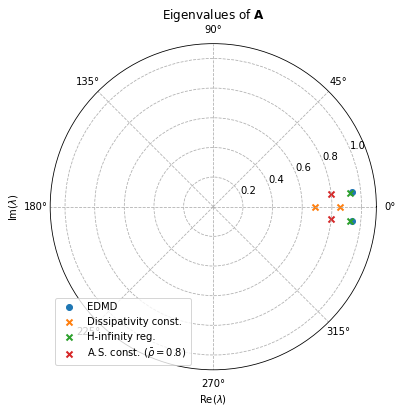

In [9]:
def plt_eig(A: np.ndarray,
        ax: plt.Axes,
        label: str = '',
        marker: str = 'x') -> None:
    """Eigenvalue plotting helper function."""
    eigv = linalg.eig(A)[0]
    ax.scatter(np.angle(eigv), np.absolute(eigv), marker=marker, label=label)


fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(projection='polar')
ax.set_xlabel(r'$\mathrm{Re}(\lambda)$')
ax.set_ylabel(r'$\mathrm{Im}(\lambda)$', labelpad=30)
plt_eig(U_no_const[:2, :2], ax, 'EDMD', marker='o')
plt_eig(U_diss_const[:2, :2], ax, r'Dissipativity const.')
plt_eig(U_hinf_reg[:2, :2], ax, r'H-infinity reg.')
plt_eig(
    U_sr_const[:2, :2],
    ax,
    r'A.S. const. ($\bar{\rho}=0.8$)',
)
ax.set_rmax(1.1)
ax.legend(loc='lower left')
ax.set_title(r'Eigenvalues of $\bf{A}$')